In [18]:
import requests
import pandas as pd
from collections import defaultdict

# Constants
MARKETS_API = "https://api.kamino.finance/v2/kamino-market"
METRICS_API_TEMPLATE = "https://api.kamino.finance/kamino-market/{}/metrics/history?env=mainnet-beta&start=2023-01-01&end=2025-05-06"
PROGRAM_ID = "KLend2g3cP87fffoy8q1mQqGKjrxjC8boSyAYavgmjD"

def fetch_lending_markets():
    url = f"{MARKETS_API}?programId={PROGRAM_ID}"
    response = requests.get(url)
    response.raise_for_status()
    return [m["lendingMarket"] for m in response.json() if "lendingMarket" in m]

def fetch_market_metrics(market_id):
    url = METRICS_API_TEMPLATE.format(market_id)
    response = requests.get(url)
    response.raise_for_status()
    return response.json()

def get_daily_averages_for_market(metrics):
    daily = defaultdict(lambda: {"borrowTVL": [], "depositTVL": []})
    for entry in metrics:
        date = entry["timestamp"][:10]
        borrow = float(entry["metrics"].get("borrowTVL", 0))
        deposit = float(entry["metrics"].get("depositTVL", 0))
        daily[date]["borrowTVL"].append(borrow)
        daily[date]["depositTVL"].append(deposit)

    records = []
    for date, vals in daily.items():
        avg_borrow = sum(vals["borrowTVL"]) / len(vals["borrowTVL"])
        avg_deposit = sum(vals["depositTVL"]) / len(vals["depositTVL"])
        records.append({
            "date": date,
            "avg_borrowTVL": avg_borrow,
            "avg_depositTVL": avg_deposit
        })

    df = pd.DataFrame(records)
    return df.set_index("date")

def main():
    print("Fetching lending markets...")
    markets = fetch_lending_markets()

    market_dfs = []
    for idx, market in enumerate(markets):
        print(f"[{idx+1}/{len(markets)}] Fetching data for market: {market}")
        try:
            data = fetch_market_metrics(market)
            df = get_daily_averages_for_market(data)
            market_dfs.append(df)
        except Exception as e:
            print(f"⚠️ Error fetching market {market}: {e}")

    if not market_dfs:
        print("No data to process.")
        return

    print("Combining all market data...")
    stacked_df = pd.concat(market_dfs)

    combined_df = (
        stacked_df
        .groupby(stacked_df.index)
        .sum(min_count=1)
        .reset_index()
        .rename(columns={
            "index": "date",  # fallback if index is unnamed
            "avg_borrowTVL": "total_avg_borrowTVL",
            "avg_depositTVL": "total_avg_depositTVL"
        })
    )

    if "index" in combined_df.columns:
        combined_df = combined_df.rename(columns={"index": "date"})

    # Remove NaN rows
    combined_df = combined_df.dropna(subset=["total_avg_borrowTVL", "total_avg_depositTVL"])

    # Write to CSV
    output_file = "kamino_daily_aggregates.csv"
    combined_df.to_csv(output_file, index=False)
    print(f"✅ Done! CSV saved to: {output_file}")

if __name__ == "__main__":
    main()


Fetching lending markets...
[1/14] Fetching data for market: 7u3HeHxYDLhnCoErrtycNokbQYbWGzLs6JSDqGAv5PfF
[2/14] Fetching data for market: DxXdAyU3kCjnyggvHmY5nAwg5cRbbmdyX3npfDMjjMek
[3/14] Fetching data for market: ByYiZxp8QrdN9qbdtaAiePN8AAr3qvTPppNJDpf5DVJ5
[4/14] Fetching data for market: BJnbcRHqvppTyGesLzWASGKnmnF1wq9jZu6ExrjT7wvF
[5/14] Fetching data for market: H6rHXmXoCQvq8Ue81MqNh7ow5ysPa1dSozwW3PU1dDH6
[6/14] Fetching data for market: 4UwtBqa8DDtcWV6nWFregeMVkGdfWfiYeFxoHaR2hm9c
[7/14] Fetching data for market: GMqmFygF5iSm5nkckYU6tieggFcR42SyjkkhK5rswFRs
[8/14] Fetching data for market: 3EZEy7vBTJ8Q9PWxKwdLVULRdsvVLT51rpBG3gH1TSJ5
[9/14] Fetching data for market: 9wmqLq3n3KdQBbNfwqrF3PwcLgZ9edZ7hW5TsaC3o6uj
[10/14] Fetching data for market: GVDUXFwS8uvBG35RjZv6Y8S1AkV5uASiMJ9qTUKqb5PL
[11/14] Fetching data for market: F4Pn9mAvbUazDmWET5yYATTiyLHLaCRTWgGex4tiMXAs
[12/14] Fetching data for market: CuSNbDHVEXGfptpnbDRW5VxTRhGsz7BrudK95cJhH8uV
[13/14] Fetching data for market:

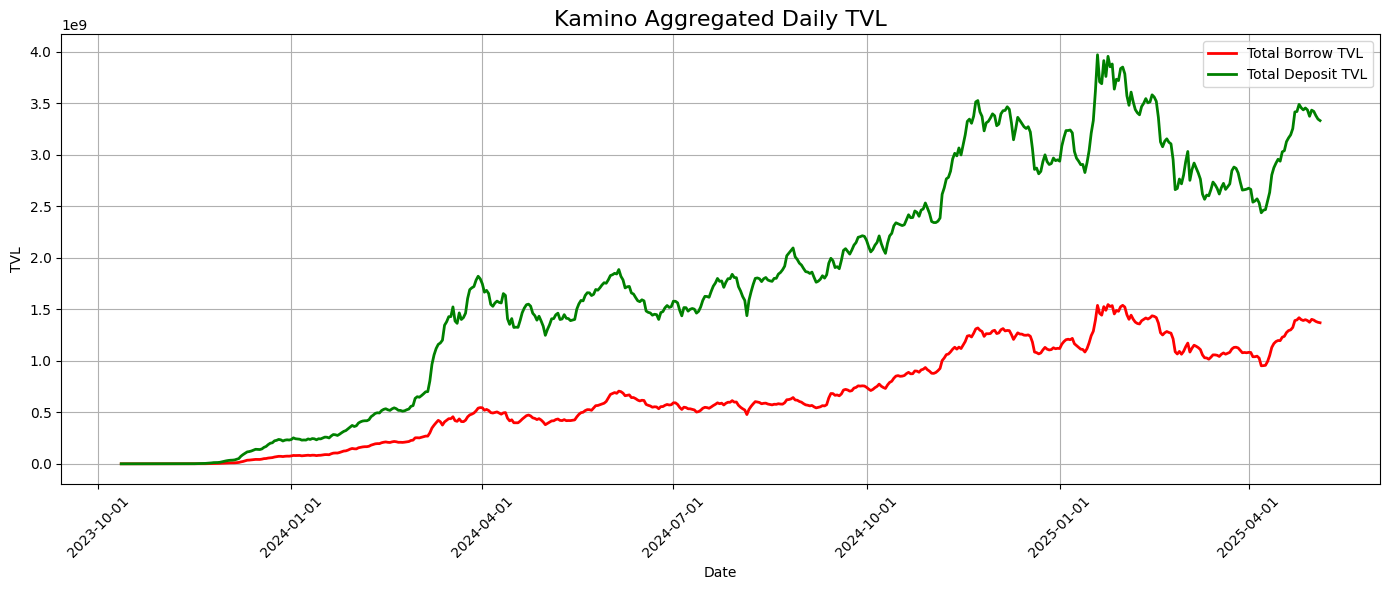

In [21]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def plot_aggregated_metrics(df):
    # Convert date column to datetime just in case
    df["date"] = pd.to_datetime(df["date"])

    plt.figure(figsize=(14, 6))
    plt.plot(df["date"], df["total_avg_borrowTVL"], label="Total Borrow TVL", color="red", linewidth=2)
    plt.plot(df["date"], df["total_avg_depositTVL"], label="Total Deposit TVL", color="green", linewidth=2)

    plt.title("Kamino Aggregated Daily TVL", fontsize=16)
    plt.xlabel("Date")
    plt.ylabel("TVL")
    plt.legend()
    plt.grid(True)

    # Format x-axis for better date visibility
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=5, maxticks=10))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_aggregated_metrics(combined_df)